In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

# Add lib to PYTHONPATH
lib_path = osp.join('./', 'lib')
add_path(lib_path)

coco_path = osp.join('./', 'data', 'coco', 'PythonAPI')
add_path(coco_path)

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


In [2]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [3]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [4]:
demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]

Loaded network output/res101/voc_2007_trainval+voc_2012_trainval/default/res101_faster_rcnn_iter_110000.pth
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000456.jpg
Detection took 1.650s for 300 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/000542.jpg
Detection took 0.128s for 185 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001150.jpg
Detection took 0.115s for 170 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/001763.jpg
Detection took 0.136s for 246 object proposals
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/004545.jpg
Detection took 0.112s for 300 object proposals


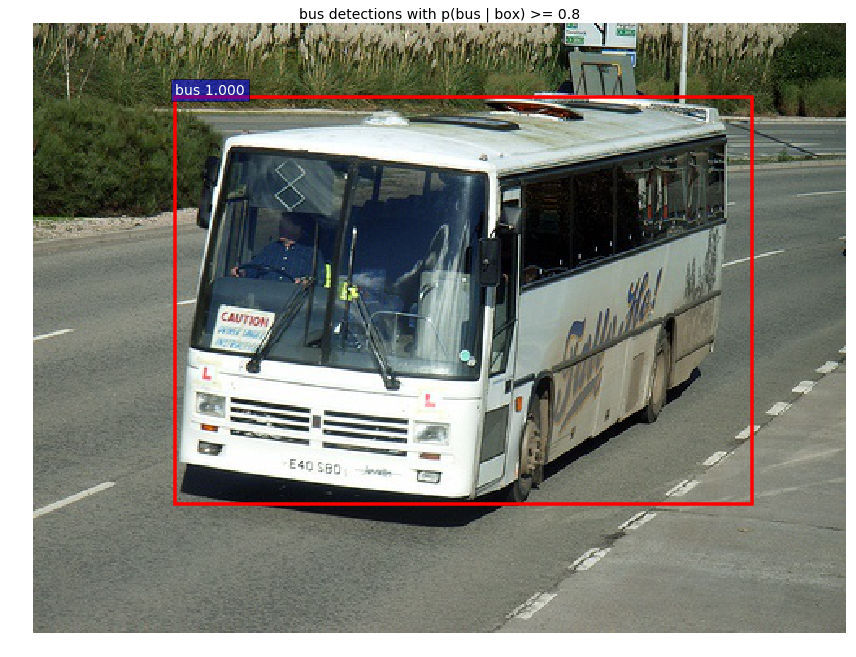

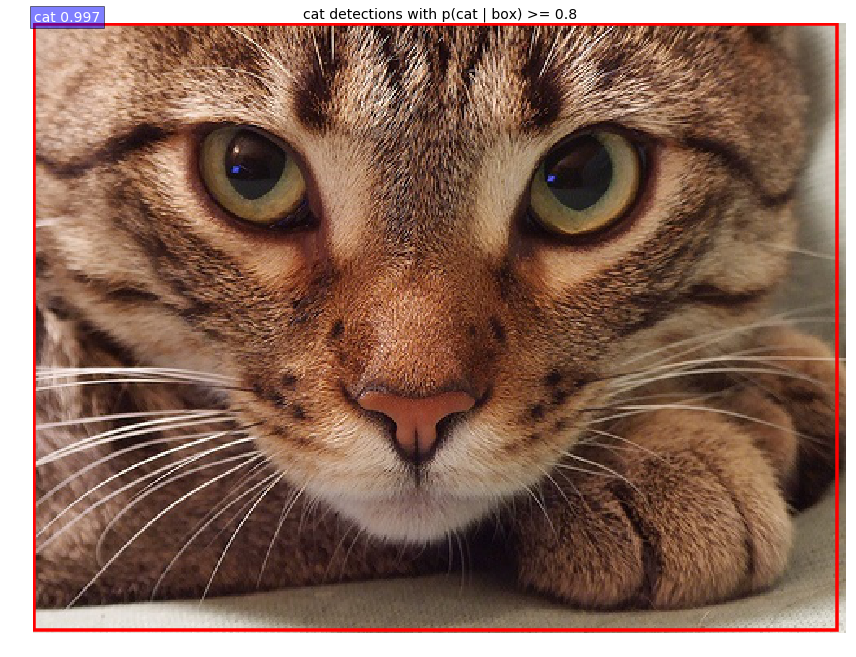

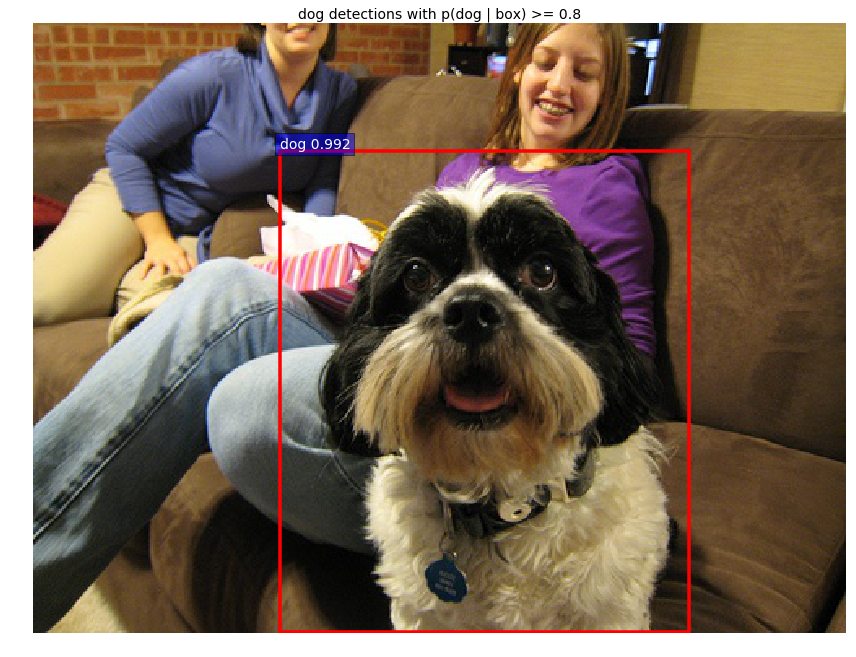

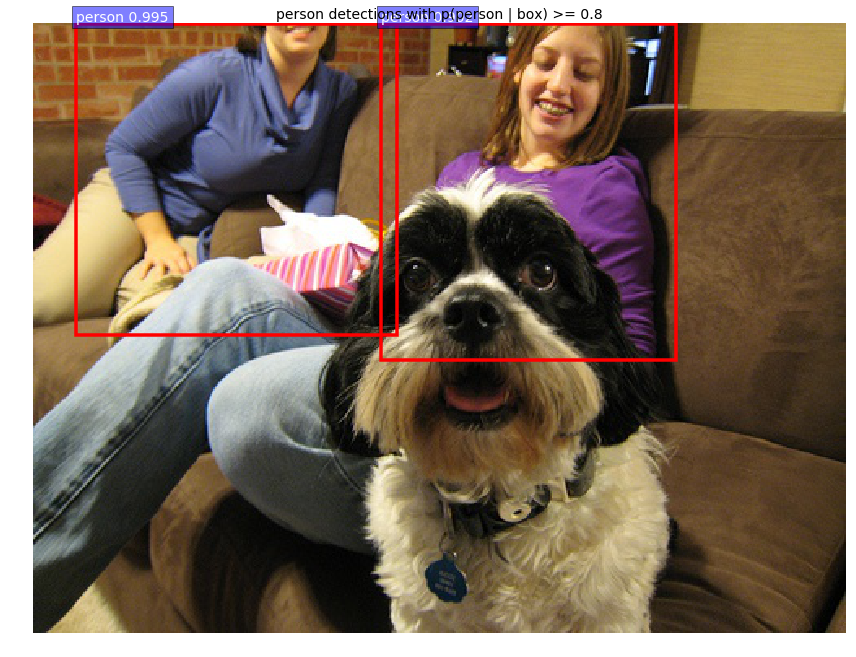

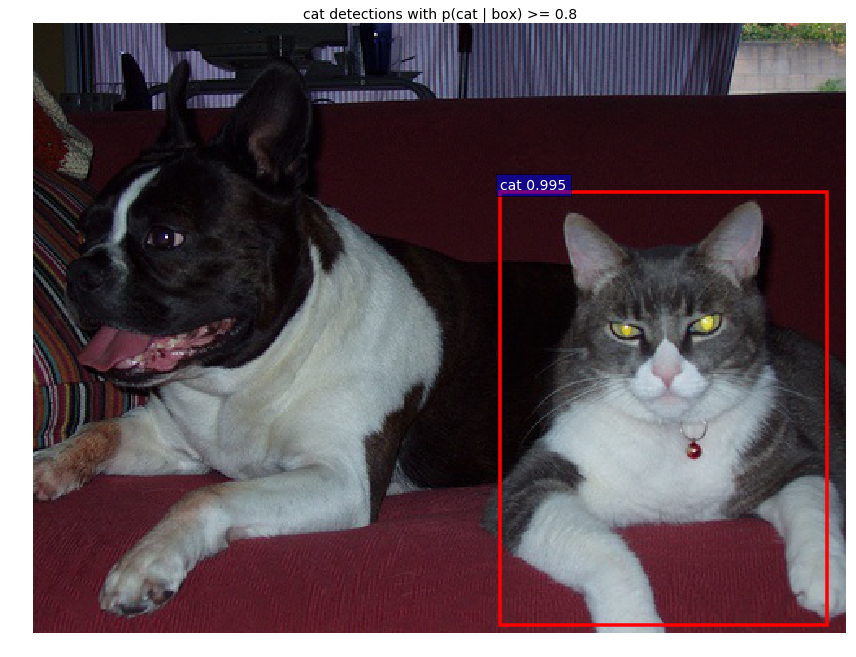

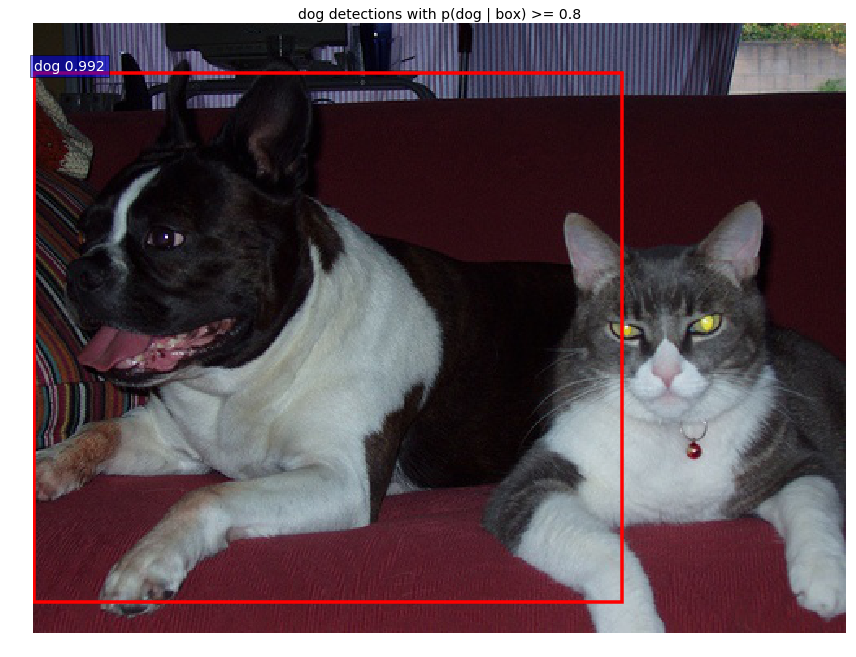

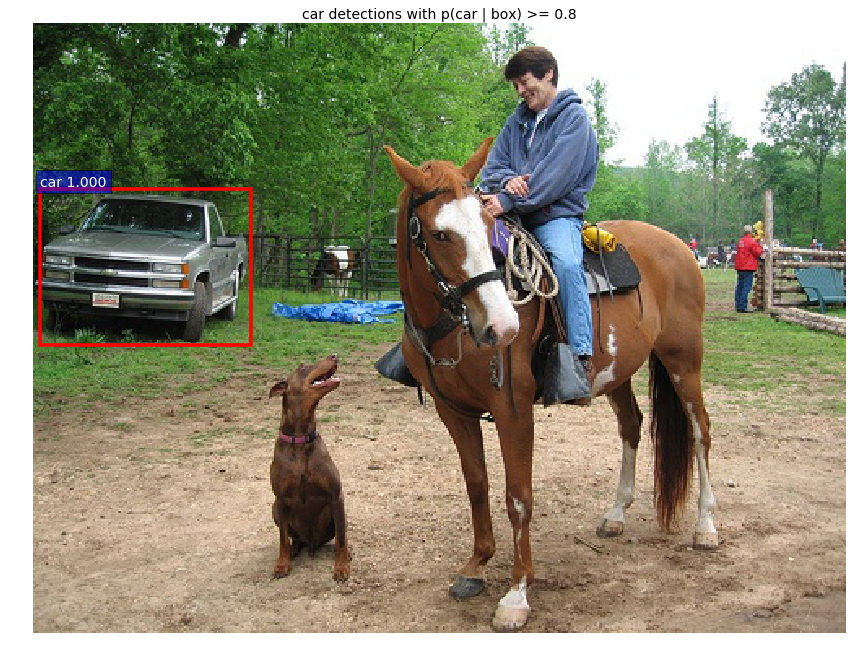

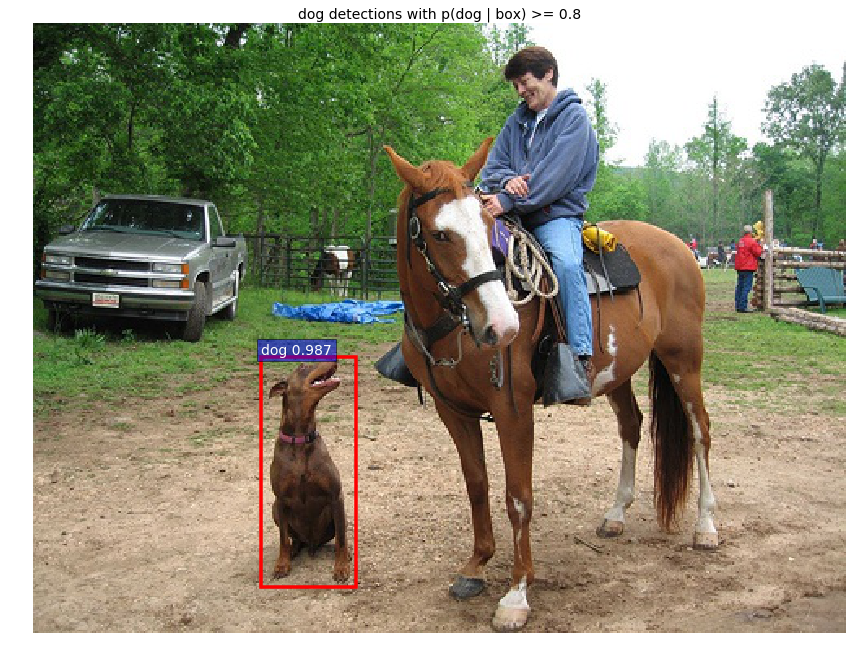

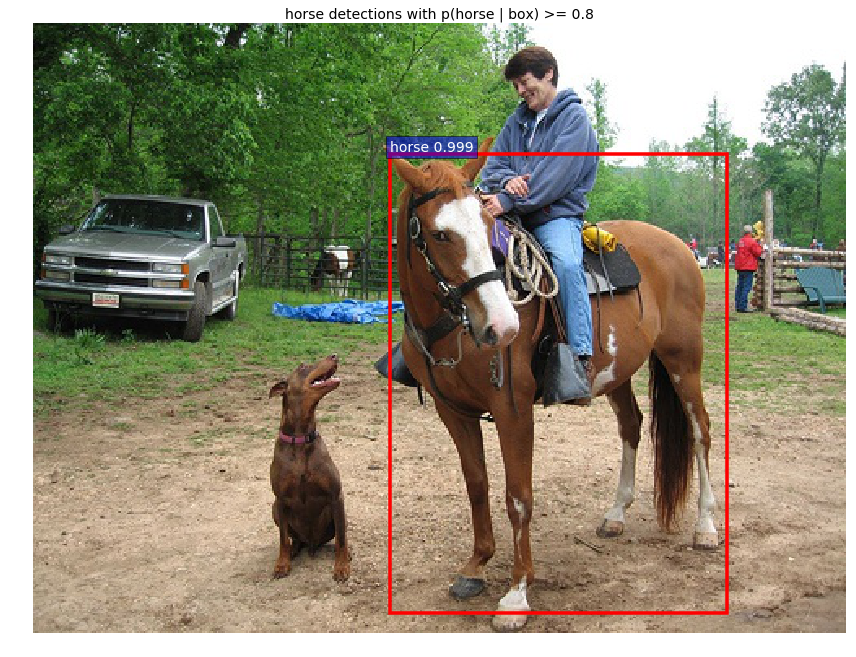

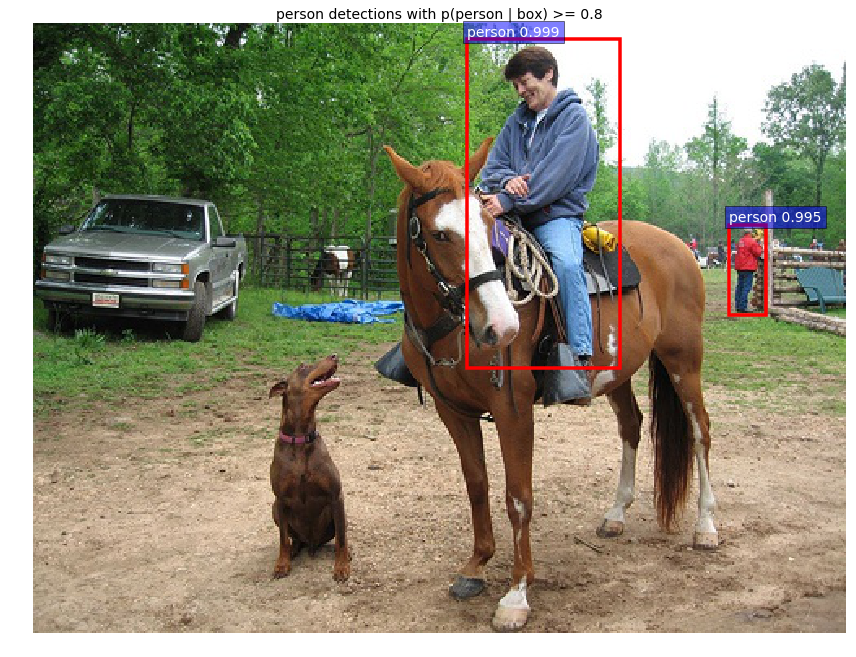

In [5]:
if True:
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('output', demonet, DATASETS[dataset][0], 'default',
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(21,
                          tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(saved_model))

    net.eval()
    net.cuda()

    print('Loaded network {:s}'.format(saved_model))

    im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
                '001763.jpg', '004545.jpg']
    for im_name in im_names:
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('Demo for data/demo/{}'.format(im_name))
        demo(net, im_name)

    plt.show()
